# The Askeladden Algorithm <a class="tocSkip">

## W207 | Applied Machine Learning | Spring 2019<a class="tocSkip">

### Team Troll Trappers: Laura Pintos, Ramiro Cadavid, and Anna Jacobson<a class="tocSkip">

## Introduction

In February 2019, as part of special counsel Robert Mueller’s investigation of the Russian government's efforts to interfere in the 2016 presidential election, the United States Department of Justice charged 13 Russian nationals with illegally meddling in American political processes. The defendants worked for a well-funded “troll factory” called the Internet Research Agency (IRA), which reportedly had 400 employees, or “trolls”,  working 12-hour shifts from a nondescript business center in St. Petersburg. The IRA ran a sophisticated, coordinated campaign to spread disinformation and sow discord into American politics via social media, often Twitter. 

Twitter has identified and suspended thousands of these malicious accounts, deleting millions of the trolls’ tweets from public view on the platform. While other news outlets have published samples, it has been difficult to understand the full scale and scope of the IRA’s efforts, as well as the details of its strategy and tactics. According to Alina Polyakova, a foreign policy fellow at the Brookings Institution, “Wiping the content doesn’t wipe out the damage caused, and it prevents us from learning about how to be better prepared for such attacks in the future.” To address this problem, and “in line with our principles of transparency and to improve public understanding of alleged foreign influence campaigns,” Twitter has now made publicly available archives of Tweets and media that it believes resulted from potentially state-backed information operations.

More than 20% of the English-language troll tweets came from accounts with user names that mimicked those of legitimate news outlets. The purpose of this project is to try to predict "fake news" troll tweets.

**Setup**

In [1]:
# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import string
import csv
import datetime
import pandas_ml as pdml
import seaborn as sns
from collections import defaultdict

#SK-learn libraries for preprocessing
from sklearn.datasets import fetch_mldata
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from textblob import TextBlob

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

# SK-learn libraries for model selection and evaluation.
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Complementary libraries
from pandas_ml import ConfusionMatrix
from pprint import pprint
from time import time
from wordcloud import WordCloud
from pylab import *

# Set seed for random states
seed = 2019

## The Data

### Data Sources

#### Troll Tweets

Twitter has published a collection of datasets includes all public, undeleted tweets and media (e.g., images and videos) for 3,613 accounts that Twitter believes are connected to the Russian state-backed information operation Internet Research Agency (IRA). Tweets deleted by these users prior to their suspension (which are not included in these datasets) comprise less than 1% of their overall activity. The data consists of the full archive of information disclosed about the IRA. We decided to focus on the tweets dataset, which includes 8,768,633 unique tweets from May 2009 to June 2018. After filtering for English language tweets only, there are just under 3 million unique tweets in the dataset (2,997,181). These tweets come from 3,077 unique user accounts.

We defined our period of interest as 2016-2018. In order to segregate the "fake news" trolls, we filtered for user screen names containing the words 'Daily', 'New', 'Today', and 'Online'. This yielded 296,949 unique tweets from 33 unique user accounts with screen names such as TodayNYCity, ChicagoDailyNew, and KansasDailyNews. We randomly sampled this set of data to get the same number of tweets as our real news tweet dataset (see below).

#### Real News Tweets

Harvard Dataverse has published a dataset containing the tweet IDs of 39,695,156 tweets collected from the Twitter accounts of approximately 4,500 news outlets (i.e., accounts of media organizations intended to disseminate news). The media organizations include everything from local U.S. newspapers to foreign television stations. They were collected between August 4, 2016 and July 20, 2018 from the Twitter API. 

Twitter's Developer Policy (which you agree to when you get keys for the Twitter API) places limits on the sharing of datasets. If you are sharing datasets of tweets, you can only publicly share the ids of the tweets, not the tweets themselves. Thus, this dataset, only contained the tweets ids. Based on the tweet ID, we retrieved the complete tweet from the Twitter API. We selected a variety of news outlets, including Politico, Fox News, CNN, The Economist, and MSNBC. In total, we have included 153,188 unique tweets from 49 unique user accounts.

#### Combined News Tweets

For this analysis, we combined the troll tweets and the real news tweets, for a combined dataset of 306,376 tweets equally balanced between the two classes. We included the text of each tweet and its category ('real' or 'troll'). No other identifying information is included.

### Data Preparation

Load data and check balance

In [2]:
df = pd.read_csv("Data/news_tweets_big.csv", index_col=0)
df.category.value_counts()

troll    153188
real     153188
Name: category, dtype: int64

Preview troll and real news tweets

In [15]:
print("Troll tweets")
df[df.category == 'troll'].head()

Troll tweets


,tweet_text,category
0,Brewers-Cubs first pitch scheduled for 2:15 p....,troll
1,Even more medicine coming to Liberty Township ...,troll
2,Chicago fugitive apprehended in Lithonia https...,troll
3,11 killed in East TN wildfires; TBI investigat...,troll
4,GOP campaigns flock to Fargo to vie for delega...,troll


In [16]:
print("Real news tweets")
df[df.category == 'real'].head()

Real news tweets


,tweet_text,category
153188,Russia shrugs off reports Trump shared classif...,real
153189,Texas man reportedly imprisoned in United Arab...,real
153190,Giannis Antetokounmpo jumped over a 6-foot-6 d...,real
153191,Dramatic mood shift at Clinton HQ; Many aides ...,real
153192,RT @JaniceDean: A warm up for the eastern half...,real


Factorize categories

In [3]:
# Factorize the categories.
d = {'real':0, 'troll':1}
df['category'] = df['category'].map(d)
print(df.category.value_counts())

# Check that troll = 1 (and therefore, real = 0).
df[df.category == 1].head()

1    153188
0    153188
Name: category, dtype: int64


,tweet_text,category
0,Brewers-Cubs first pitch scheduled for 2:15 p....,1
1,Even more medicine coming to Liberty Township ...,1
2,Chicago fugitive apprehended in Lithonia https...,1
3,11 killed in East TN wildfires; TBI investigat...,1
4,GOP campaigns flock to Fargo to vie for delega...,1


Set category as target

In [4]:
my_df = pd.DataFrame(df,columns=['tweet_text'])
my_df['target'] = df.category
my_df.head()

,tweet_text,target
0,Brewers-Cubs first pitch scheduled for 2:15 p....,1
1,Even more medicine coming to Liberty Township ...,1
2,Chicago fugitive apprehended in Lithonia https...,1
3,11 killed in East TN wildfires; TBI investigat...,1
4,GOP campaigns flock to Fargo to vie for delega...,1


### Initial Data Exploration

Preview meta-data

In [5]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306376 entries, 0 to 306375
Data columns (total 2 columns):
tweet_text    306376 non-null object
target        306376 non-null int64
dtypes: int64(1), object(1)
memory usage: 7.0+ MB


Generate word cloud for each category

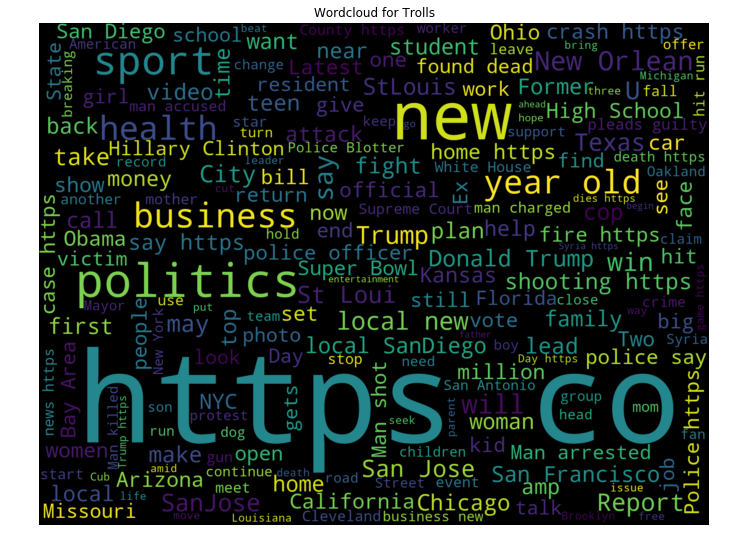

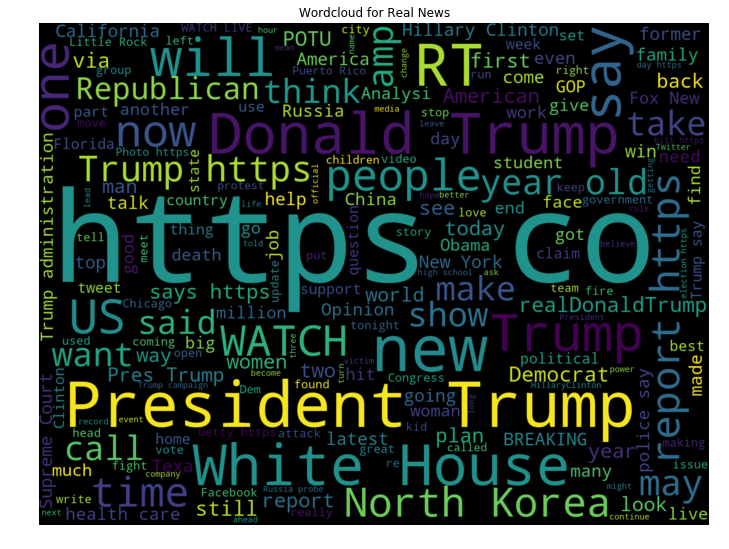

In [20]:
def wordcloud(target, category):
    '''
    Args:
        target (int): selected target for which to generate wordcloud
    ''' 
    # Strings to list of words
    tweets = my_df[my_df.target == target]
    string = []
    for t in tweets.tweet_text:
        string.append(t)
    string = pd.Series(string).str.cat(sep=' ')
    
    # Plot word cloud
    wordcloud = WordCloud(width=1600, height=1200,
                          max_font_size=300).generate(string)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title('Wordcloud for %s'%category, fontsize = 12)
    plt.axis("off")
    plt.show()

# Generate wordcloud for troll and real tweets.
wordcloud(1, 'Trolls')
wordcloud(0, 'Real News')

### Initial Feature Extraction Exploration

In order to better understand our data, we perform a light-touch feature extraction.

In [21]:
# Instantiate the vectorizer and fit the tweet text data.
cvec = CountVectorizer()
cvec.fit(my_df.tweet_text)

# # Number of features
print("Number of features = {0:,}".format(len(cvec.get_feature_names())))

""" 
Most frequently used features
"""
# Vectorize tweet text per category
real_doc_matrix = cvec.transform(my_df[my_df.target == 0].tweet_text)
troll_doc_matrix = cvec.transform(my_df[my_df.target == 1].tweet_text)

# Build term-frequency matrix
real_tf = np.sum(real_doc_matrix,axis=0)
troll_tf = np.sum(troll_doc_matrix,axis=0)
real = np.squeeze(np.asarray(real_tf))
troll = np.squeeze(np.asarray(troll_tf))
term_freq_df = pd.DataFrame([real,troll], columns=cvec.get_feature_names()).transpose()

# Build term-frequency per word, for each category
term_freq_df.columns = ['real', 'troll']
term_freq_df['total'] = term_freq_df['real'] + term_freq_df['troll']
print("\nTerm frequency per label:")
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

Number of features = 470,051

Term frequency per label:


,real,troll,total
https,195129,200634,395763
co,193992,201048,395040
to,57108,36722,93830
the,75335,15924,91259
in,41252,46682,87934
of,40905,23588,64493
for,24091,21394,45485
on,24203,15026,39229
trump,30352,8168,38520
and,25274,8751,34025


Plot the top 50 features for each category

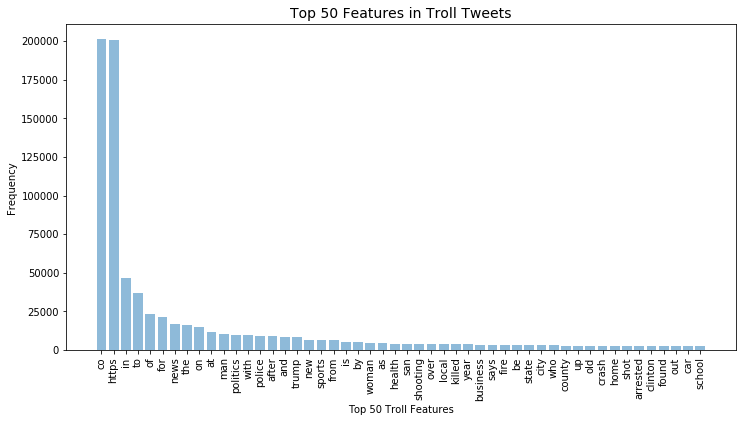

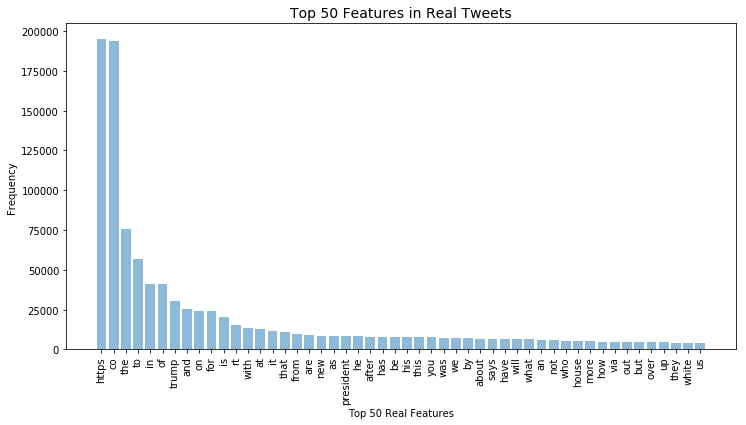

In [22]:
# Define function that plots top 50 features
def top_features(category):    
    '''
    args:
        category (str): specified category name.
    returns:
        (none): plots top 50 features.
    '''
    y_pos = np.arange(50)
    plt.figure(figsize=(12,6))
    plt.bar(y_pos, term_freq_df.sort_values(by=category, ascending=False)[category][:50], 
            align='center', alpha=0.5)
    plt.xticks(y_pos, term_freq_df.sort_values(by=category, ascending=False)[category][:50].index,rotation='vertical')
    plt.ylabel('Frequency')
    plt.xlabel('Top 50 %s Features'%category.title())
    plt.title('Top 50 Features in %s Tweets'%category.title(), fontsize=14)

# Run top_features for each category
top_features('troll')
top_features('real')

Frequency of features per category

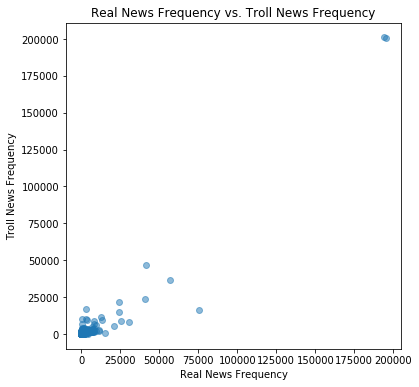

In [23]:
plt.figure(figsize=(6,6));
ax = sns.regplot(x="real", y="troll",fit_reg=False, 
                 scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Troll News Frequency')
plt.xlabel('Real News Frequency')
plt.title('Real News Frequency vs. Troll News Frequency');

### Data Split

In [6]:
# Split data into training, development, and test datasets.
x = my_df.tweet_text
y = my_df.target
x_train, x_dev_and_test, y_train, y_dev_and_test = train_test_split(x, y, test_size=0.2, random_state=seed)
x_dev, x_test, y_dev, y_test = train_test_split(x_dev_and_test, y_dev_and_test, test_size=0.5, random_state=seed)
targets = ['real','troll']

# Print results
print(f"""
Training data shape: ({x_train.shape[0]:,}, )
Development data shape: ({x_dev.shape[0]:,}, )
Test data shape: ({x_test.shape[0]:,}, )
Labels: ({targets[0]:s}, {targets[1]:s})
""")


Training data shape: (245,100, )
Development data shape: (30,638, )
Test data shape: (30,638, )
Labels: (real, troll)



## Initial Modeling

### Models 1-2: Bernoulli Naive Bayes

Define Bernoulli Naive-Bayes function

In [19]:
def bnb_cv(alphas, vectorizer):
    '''
    Args:
        alphas (list): list of alpha values to try
        
    Returns:
        (none): prints best alpha in CV and corresponding
            accuracy score.
    '''
    # Train vectorizer on train data and train and development data.
    vectorizer = vectorizer
    train_dtm = vectorizer.fit_transform(x_train)
    dev_dtm = vectorizer.transform(x_dev)
    
    # Train Bernoulli NB model on train data and predict on dev data.
    bnb = BernoulliNB().fit(train_dtm, y_train)
    y_pred_P3b = bnb.predict(dev_dtm)
   
    # Implement and fit GridSearchCV.
    gscv = GridSearchCV(BernoulliNB(), alphas, cv=3, scoring='accuracy')
    gscv.fit(train_dtm, y_train)
    
    # Print results.
    print('Best alpha: %0.4f' % gscv.best_params_['alpha'])
    print('Accuracy: %3.4f' %(bnb.score(dev_dtm, y_dev)))

#### Model 1: CountVectorizer BNB

In [20]:
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}
bnb_cv(alphas, CountVectorizer())

Best alpha: 0.1000
Accuracy: 0.8608


#### Model 2: TFIDFVectorizer BNB

In [21]:
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}
bnb_cv(alphas, TfidfVectorizer())

Best alpha: 0.1000
Accuracy: 0.8608


Model 3: Intentionally Omitted

### Models 4-6: CountVectorizer Logistic Regression

Define functions

In [76]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    """ Calculates accuracy and compares it with baseline.
    
    Args:
        pipeline (Pipepline): Steps performed to preprocess and fit model.
        
        x_train (array): training data.
        
        y_train (array): trainin labels.
        
        x_test (array): test data.
        
        y_test (array): test labels.
    
    Returns:
        accuracy (float): accuracy of trained model, on test data.
        
        train_test_time (float): time taken for model to fit and predict.
        
        null_accuracy (float): baseline accuracy.
    """
    # Calculate baseline accuracy
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    from time import time
    t0 = time()
    
    # Fit model on training data and find accuracy on test data
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, train_test_time, null_accuracy     

def nfeature_accuracy_checker(vectorizer=CountVectorizer(stop_words=None), ngram_range=(1, 1),
                              classifier=LogisticRegression(solver='liblinear')):
    """Calculates accuracy, improvement with respect to baseline and train-test time
    for different number of features.
    
    Args:
        vectorizer (vectorizer): vectorizer used for transforming string to
            frequency representation.
        
        ngram_range (array): 2-tuple indicating the ngrams used by vectorizer.
        
        classifier (classifier): algorithm that is trained.
    
    Returns:
        (DataFrame): data frame containing the accuracy, improvement and time
            for different number of features.
    """
    data = []   
    n_features = [5, 25, 50, 75, 100, 250, 1000, 10000, 100000, 500000]
    for n in n_features:
        # Set vectorizer's parameters and define pipeline
        vectorizer.set_params(max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([('vectorizer', vectorizer), ('classifier', classifier)])
        
        # Calculate accuracy, time and improvement (combine in single list)
        nfeature_accuracy, tt_time, null_accuracy = accuracy_summary(checker_pipeline, 
                                                                     x_train, y_train, 
                                                                     x_dev, y_dev)
        improvement = (nfeature_accuracy - null_accuracy) * 100
        data.append([n, nfeature_accuracy * 100, improvement, tt_time])
    
    # Combine in data frame
    columns = ['Features', 'Accuracy', 'Improvement', 'Train-test time']
    return pd.DataFrame(data=data, columns=columns)

#### Model 4: Unigram CV

In [56]:
feature_result_ug = nfeature_accuracy_checker(ngram_range=(1, 1))
feature_result_ug

,Features,Accuracy,Improvement,Train-test time
0,5,62.964293,12.931654,8.502282
1,25,73.836412,23.803773,7.624664
2,50,77.465892,27.433253,7.416151
3,75,78.653959,28.621320,8.320733
4,100,79.825707,29.793067,8.081409
5,250,81.692669,31.660030,9.972388
6,1000,84.502905,34.470266,10.918794
7,10000,87.714603,37.681964,18.440695
8,100000,88.246622,38.213983,22.942709
9,500000,88.230302,38.197663,24.256192


#### Model 5: Bigram CV

In [48]:
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))
feature_result_bg

,Features,Accuracy,Improvement,Train-test time
0,5,64.452641,14.420001,21.853612
1,25,73.232587,23.199948,22.633528
2,50,77.211306,27.178667,23.120275
3,75,78.722501,28.689862,22.009183
4,100,79.828971,29.796331,23.666569
5,250,81.418500,31.385861,24.872491
6,1000,84.473530,34.440890,27.574326
7,10000,87.770089,37.737450,29.967904
8,100000,89.160520,39.127880,39.135404
9,500000,89.522815,39.490176,59.636672


#### Model 6: Trigram CV

In [49]:
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))
feature_result_tg

,Features,Accuracy,Improvement,Train-test time
0,5,64.452641,14.420001,42.956230
1,25,73.232587,23.199948,45.016724
2,50,77.211306,27.178667,45.193294
3,75,78.722501,28.689862,45.181963
4,100,79.828971,29.796331,46.931566
5,250,81.411972,31.379333,45.348858
6,1000,84.450682,34.418043,50.069226
7,10000,87.828840,37.796201,52.844765
8,100000,88.824336,38.791697,69.379632
9,500000,89.349827,39.317188,101.391103


#### Comparison of different ngrams

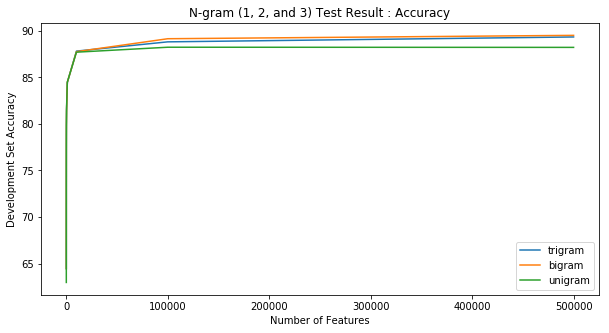

In [62]:
# Setup plot
plt.figure(figsize=(10,5))
plt.title("N-gram (1, 2, and 3) Test Result : Accuracy")
plt.xlabel("Number of Features")
plt.ylabel("Development Set Accuracy")

# Plot model for each ngram
plt.plot(feature_result_tg['Features'], feature_result_tg['Accuracy'], label='trigram')
plt.plot(feature_result_bg['Features'], feature_result_bg['Accuracy'], label='bigram')
plt.plot(feature_result_ug['Features'], feature_result_ug['Accuracy'], label='unigram')
plt.legend();

The bigram model shows the best accuracy. The trigram model has a similar curve with slightly less accuracy. The unigram model clearly performs the worst of the three.

### Models 7-9: TFIDFVectorizer Logistic Regression

#### Model 7: Unigram TFIDF

In [77]:
feature_result_ugt = nfeature_accuracy_checker(vectorizer=TfidfVectorizer(),
                                              ngram_range=(1, 1))
feature_result_ugt

,Features,Accuracy,Improvement,Train-test time
0,5,64.912853,14.880214,7.232646
1,25,73.523076,23.490437,8.380608
2,50,77.661727,27.629088,7.851972
3,75,78.755141,28.722501,8.233001
4,100,79.685358,29.652719,8.523239
5,250,81.320582,31.287943,8.888200
6,1000,84.029636,33.996997,9.186457
7,10000,87.110777,37.078138,10.109982
8,100000,87.597102,37.564462,10.949743
9,500000,87.890854,37.858215,11.764600


#### Model 8: Bigram TFIDF

In [78]:
feature_result_bgt = nfeature_accuracy_checker(vectorizer=TfidfVectorizer(),
                                              ngram_range=(1, 2))
feature_result_bgt

,Features,Accuracy,Improvement,Train-test time
0,5,64.903062,14.870422,21.364966
1,25,73.434950,23.402311,21.494517
2,50,77.381030,27.348391,21.694037
3,75,78.826947,28.794308,22.237585
4,100,79.721261,29.688622,22.423089
5,250,81.176970,31.144331,25.158108
6,1000,84.107970,34.075331,24.541476
7,10000,87.345780,37.313141,26.204943
8,100000,88.011620,37.978980,24.461605
9,500000,87.825576,37.792937,28.680339


#### Model 9: Trigram TFIDF

In [80]:
feature_result_tgt = nfeature_accuracy_checker(vectorizer=TfidfVectorizer(),
                                              ngram_range=(1, 3))
feature_result_tgt

,Features,Accuracy,Improvement,Train-test time
0,5,64.903062,14.870422,45.054024
1,25,73.434950,23.402311,44.792357
2,50,77.381030,27.348391,43.117754
3,75,78.826947,28.794308,43.364363
4,100,79.721261,29.688622,45.220180
5,250,81.173706,31.141067,44.094189
6,1000,84.062276,34.029636,47.097122
7,10000,87.264182,37.231543,46.536251
8,100000,87.877799,37.845160,49.228525
9,500000,87.776617,37.743978,50.798281


#### Comparison of different ngrams and vectorizers

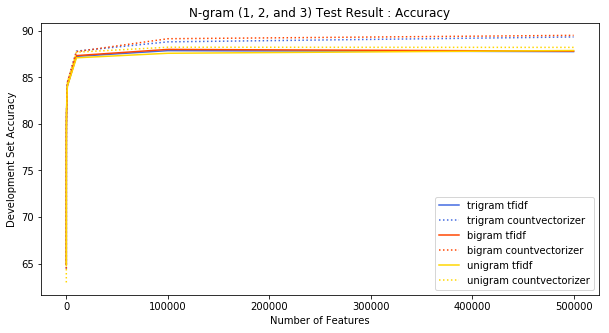

In [81]:
# Setup plot
plt.figure(figsize=(10,5))
plt.title("N-gram (1, 2, and 3) Test Result : Accuracy")
plt.xlabel("Number of Features")
plt.ylabel("Development Set Accuracy")

# Plot model for each ngram
plt.plot(feature_result_tgt['Features'], feature_result_tgt['Accuracy'],
         label='trigram tfidf', color='royalblue')
plt.plot(feature_result_tg['Features'], feature_result_tg['Accuracy'],
         label='trigram countvectorizer', color='royalblue', linestyle=':')

plt.plot(feature_result_bgt['Features'], feature_result_bgt['Accuracy'],
         label='bigram tfidf', color='orangered')
plt.plot(feature_result_bg['Features'], feature_result_bg['Accuracy'],
         label='bigram countvectorizer', color='orangered', linestyle=':')

plt.plot(feature_result_ugt['Features'], feature_result_ugt['Accuracy'],
         label='unigram tfidf', color='gold')
plt.plot(feature_result_ug['Features'], feature_result_ug['Accuracy'],
         label='unigram countvectorizer', color='gold', linestyle=':')
plt.legend();

Unlike with CountVectorizer, the TFIDF unigram model performs best. However, the CountVectorizer models are more accurate than the TFIDF models, particularly as the number of features increases.

### Model 10: Ensemble

In [54]:
from time import time

names = ["Logistic Regression", "Linear SVC", 
         "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron",
         "Passive-Aggresive", "Nearest Centroid", "Random Forest"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid(),
    RandomForestClassifier(),
    ]
zipped_clf = zip(names,classifiers)

cvec = CountVectorizer()

def classifier_comparator(vectorizer=cvec, n_features=10000, 
                          stop_words=None, ngram_range=(1,1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, 
                          ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print("Validation result for {}".format(n))
        print(c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, 
                                                x_train, y_train, 
                                                x_dev, y_dev)
        result.append((n,clf_accuracy,tt_time))
    return result

bigram_result = classifier_comparator(n_features=100000,ngram_range=(1,2))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.03%
accuracy score: 89.16%
model is 39.13% more accurate than null accuracy
train and test time: 50.02s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


null accuracy: 50.03%
accuracy score: 86.62%
model is 36.59% more accurate than null accuracy
train and test time: 69.50s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0),
        max_features=None, n...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
null accuracy: 50.03%
accuracy score: 87.05%
model is 37.02% more accurate than null accuracy
train and test time: 173.99s
--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
n

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


null accuracy: 50.03%
accuracy score: 81.35%
model is 31.31% more accurate than null accuracy
train and test time: 31.74s
--------------------------------------------------------------------------------
Validation result for Passive-Aggresive
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


null accuracy: 50.03%
accuracy score: 86.44%
model is 36.41% more accurate than null accuracy
train and test time: 30.16s
--------------------------------------------------------------------------------
Validation result for Nearest Centroid
NearestCentroid(metric='euclidean', shrink_threshold=None)
null accuracy: 50.03%
accuracy score: 69.64%
model is 19.61% more accurate than null accuracy
train and test time: 28.94s
--------------------------------------------------------------------------------
Validation result for Random Forest
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


null accuracy: 50.03%
accuracy score: 86.81%
model is 36.78% more accurate than null accuracy
train and test time: 382.96s
--------------------------------------------------------------------------------


In [55]:
'''
Creates an ensemble model using the best 5 algorithms above.
'''

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = BernoulliNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), 
                                    ('bnb', clf3), ('rcs', clf4), 
                                    ('pac', clf5)], voting='hard')

checker_pipeline = Pipeline([
            ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
            ('classifier', eclf)
        ])
print("Ensemble Model")
print(clf)
clf_accuracy,tt_time = accuracy_summary(checker_pipeline, 
                                        x_train, y_train, 
                                        x_dev, y_dev)

Ensemble Model
<function clf at 0x11dd39a60>


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


null accuracy: 50.03%
accuracy score: 89.81%
model is 39.78% more accurate than null accuracy
train and test time: 267.96s
--------------------------------------------------------------------------------


The ensemble model has slightly better accuracy than our previous best model, the bigram CountVectorizer logistic regression model (Model 5).

### Models 11-14: Doc2Vec

In [59]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils

In [60]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result
  
all_x = pd.concat([x_train,x_dev,x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


#### Model 11: DBOW (Distributed Bag Of Words)

In [61]:
cores = multiprocessing.cpu_count()
model_ug_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, min_count=2, 
                        workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dbow.build_vocab([x for x in tqdm(all_x_w2v)])

for epoch in range(10):
    model_ug_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), 
                        total_examples=len(all_x_w2v), epochs=1)
    model_ug_dbow.alpha -= 0.002
    model_ug_dbow.min_alpha = model_ug_dbow.alpha
    
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs
  
train_vecs_dbow = get_vectors(model_ug_dbow, x_train, 100)
dev_vecs_dbow = get_vectors(model_ug_dbow, x_dev, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dbow, y_train)
clf.score(dev_vecs_dbow, y_dev)

100%|██████████| 306376/306376 [00:00<00:00, 1828909.79it/s]
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8232586983484562

The DBOW model is not as accurate as the previous logistic regression models, nor the ensemble model (Model 10)

#### Model 12: DMC (Distributed Memory Concatenation)

In [62]:
cores = multiprocessing.cpu_count()
model_ug_dmc = Doc2Vec(dm=1, dm_concat=1, vector_size=100, window=2, 
                       negative=5, min_count=2, workers=cores, 
                       alpha=0.065, min_alpha=0.065)
model_ug_dmc.build_vocab([x for x in tqdm(all_x_w2v)])

for epoch in range(10):
    model_ug_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), 
                       total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmc.alpha -= 0.002
    model_ug_dmc.min_alpha = model_ug_dmc.alpha

train_vecs_dmc = get_vectors(model_ug_dmc, x_train, 100)
dev_vecs_dmc = get_vectors(model_ug_dmc, x_dev, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dmc, y_train)
clf.score(dev_vecs_dmc, y_dev)

100%|██████████| 306376/306376 [00:00<00:00, 2190901.92it/s]
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5685749722566747

At less than 57% accuracy, the DMC model performance is unimpressive. However, the model does seems to have learned the valid vector representation at the word level fairly well. Some examples:

In [63]:
model_ug_dmc.wv.most_similar('president')

[('president…', 0.543158233165741),
 ('president"', 0.5116411447525024),
 ('glitz', 0.4790719747543335),
 ('Philippines’', 0.4677882492542267),
 ('dictator', 0.4617164731025696),
 ('prisoner', 0.45624402165412903),
 ('irrational', 0.45077115297317505),
 ('symptom', 0.4461379647254944),
 ('dumb"', 0.4460064470767975),
 ('efficien…', 0.4407351016998291)]

In [64]:
model_ug_dmc.wv.most_similar('shooting')

[('shooting…', 0.6834243535995483),
 ('shooting;', 0.6327962875366211),
 ('stabbing', 0.6280087828636169),
 ('https://t.co/j0ogyXQxhb', 0.6174182891845703),
 ('shootout', 0.6171505451202393),
 ('stabbings', 0.6152583360671997),
 ('massacre', 0.5976384282112122),
 ('#shooting', 0.5894169211387634),
 ('carjacking', 0.587361216545105),
 ('hit-skip', 0.5820854306221008)]

#### Model 13: DMM (Distributed Memory Mean)

In [65]:
cores = multiprocessing.cpu_count()
model_ug_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmm.build_vocab([x for x in tqdm(all_x_w2v)])

for epoch in range(10):
    model_ug_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmm.alpha -= 0.002
    model_ug_dmm.min_alpha = model_ug_dmm.alpha
    
train_vecs_dmm = get_vectors(model_ug_dmm, x_train, 100)
dev_vecs_dmm = get_vectors(model_ug_dmm, x_dev, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dmm, y_train)
clf.score(dev_vecs_dmm, y_dev)

100%|██████████| 306376/306376 [00:00<00:00, 2089347.02it/s]
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7265813695410928

The DMM model far outperforms the DMC model. This is supported by examination of its learning at the word level, which also appears to be improved:

In [66]:
model_ug_dmm.wv.most_similar('president')

[('president…', 0.6244273781776428),
 ('president,', 0.6040521860122681),
 ('President…', 0.567261815071106),
 ('dictator', 0.5631226301193237),
 ('president"', 0.5224546194076538),
 ('somebody', 0.5174174308776855),
 ('versa,', 0.5083751678466797),
 ('leader', 0.5056904554367065),
 ('President', 0.5049260854721069),
 ('doctor', 0.4964512288570404)]

In [67]:
model_ug_dmc.wv.most_similar('shooting')

[('shooting…', 0.6834243535995483),
 ('shooting;', 0.6327962875366211),
 ('stabbing', 0.6280087828636169),
 ('https://t.co/j0ogyXQxhb', 0.6174182891845703),
 ('shootout', 0.6171505451202393),
 ('stabbings', 0.6152583360671997),
 ('massacre', 0.5976384282112122),
 ('#shooting', 0.5894169211387634),
 ('carjacking', 0.587361216545105),
 ('hit-skip', 0.5820854306221008)]

#### Model 14: Combined DBOW+DMM Model

In [68]:
def get_concat_vectors(model1, model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

In [69]:
train_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_train, 200)
dev_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_dev, 200)

clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmm, y_train)
clf.score(dev_vecs_dbow_dmm, y_dev)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8338011619557413

Of the Doc2Vec models, the DBOW+DMM model is the most accurate. However, the CountVectorizer logistic regression models all perform better. 

## Model 5 Development

Given the high accuracy and parsimony of our intitial CountVectorizer bigram logistic regression model (Model 5), we selected this model for further development.

### C Value Optimization

In [18]:
# Instantiates bigram CountVectorizer and transforms data.

bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                     token_pattern=r'\b\w+\b', min_df=1)
W_2 = bigram_vectorizer.fit_transform(x_train)
dev_dtm_2 = bigram_vectorizer.transform(x_dev)

In [30]:
'''
Finds the optimal C value (inverse of regularization strength) based on accuracy.
'''

def best_C(x, y):

    # C values to try
    Cs = [0.001, 0.01, 0.1, 1, 2, 5]
    
    tweets = LogisticRegressionCV(Cs=Cs, cv=5, penalty='l2', solver='saga',  
                                multi_class='multinomial', class_weight='balanced',
                                random_state=2019, scoring='accuracy', tol=0.01,
                                refit=False).fit(x, y)
    
    opt_C = tweets.C_[0]
    print(f"The optimal C value found by LogisticRegressionCV is {opt_C:.2f}.")

best_C(W_2, y_train)

The optimal C value found by LogisticRegressionCV is 4.40.


In [11]:
opt_C = 0.17

In [32]:
# Instantiate logistic regression object with best C value.
tweets1 = LogisticRegression(penalty='l2', tol=0.01, C=opt_C, solver='saga',
                            multi_class='multinomial', class_weight='balanced', 
                            random_state=2019)

# Make predictions and report accuracy.
tweets1.fit(W_2, y_train)
predicted_labels = tweets1.predict(dev_dtm_2)
print(f"Accuracy Score: {accuracy_score(y_dev, predicted_labels)*100:.2f}\n")

Accuracy Score: 89.67



Adjusting the value of C from the default of 1 to 2.00 gives us an accuracy of 89.69%, a small improvement over Model 5.

### Stop Word Removal

In [70]:
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,real,troll,total
https,195129,200634,395763
co,193992,201048,395040
to,57108,36722,93830
the,75335,15924,91259
in,41252,46682,87934
of,40905,23588,64493
for,24091,21394,45485
on,24203,15026,39229
trump,30352,8168,38520
and,25274,8751,34025


In [71]:
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', 
                                                        ascending=False).iloc[:10].index))

In [111]:
lr2 = LogisticRegression(penalty='l2', tol=0.01, C=opt_C, solver='saga',
                            multi_class='multinomial', class_weight='balanced', 
                            random_state=2019)

In [81]:
print("BIGRAM WITH ALL STOP WORDS\n")
feature_result_bg2 = nfeature_accuracy_checker(ngram_range=(1, 2), 
                                               n_features = (5, 500000),
                                               classifier = lr2)

BIGRAM WITH ALL STOP WORDS

LogisticRegression(C=2.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=0, solver='saga', tol=0.01, verbose=0,
          warm_start=False)


Validation result for 5 features
null accuracy: 50.03%
accuracy score: 64.45%
model is 14.42% more accurate than null accuracy
train and test time: 29.79s
--------------------------------------------------------------------------------
Validation result for 500000 features
null accuracy: 50.03%
accuracy score: 89.51%
model is 39.48% more accurate than null accuracy
train and test time: 49.97s
--------------------------------------------------------------------------------


In [82]:
print("BIGRAM WITHOUT STANDARD STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english', 
                                                ngram_range=(1, 2), 
                                                n_features = (5, 500000),
                                                classifier = lr2)

BIGRAM WITHOUT STANDARD STOP WORDS

LogisticRegression(C=2.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=0, solver='saga', tol=0.01, verbose=0,
          warm_start=False)


Validation result for 5 features
null accuracy: 50.03%
accuracy score: 53.94%
model is 3.91% more accurate than null accuracy
train and test time: 25.90s
--------------------------------------------------------------------------------
Validation result for 500000 features
null accuracy: 50.03%
accuracy score: 88.28%
model is 38.24% more accurate than null accuracy
train and test time: 38.50s
--------------------------------------------------------------------------------


In [83]:
print("BIGRAM WITHOUT CORPUS-SPECIFIC STOP WORDS (Top 10)\n")
feature_result_wocsw = nfeature_accuracy_checker(stop_words=my_stop_words, 
                                                 ngram_range=(1, 2), 
                                                 n_features = (5, 500000),
                                                 classifier = lr2)

BIGRAM WITHOUT CORPUS-SPECIFIC STOP WORDS (Top 10)

LogisticRegression(C=2.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=0, solver='saga', tol=0.01, verbose=0,
          warm_start=False)


Validation result for 5 features
null accuracy: 50.03%
accuracy score: 55.74%
model is 5.71% more accurate than null accuracy
train and test time: 26.54s
--------------------------------------------------------------------------------
Validation result for 500000 features
null accuracy: 50.03%
accuracy score: 88.01%
model is 37.98% more accurate than null accuracy
train and test time: 43.94s
--------------------------------------------------------------------------------


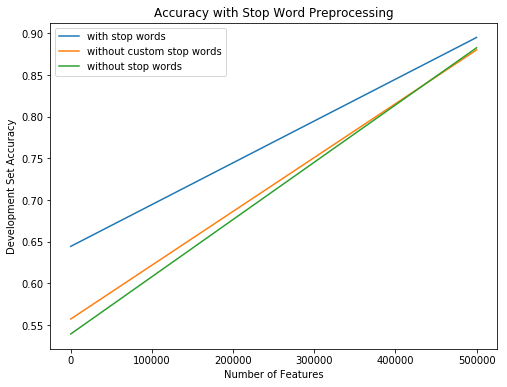

In [84]:
nfeatures_plot_bg = pd.DataFrame(feature_result_bg2,
                                 columns=['nfeatures',
                                          'validation_accuracy',
                                          'train_test_time'])
nfeatures_plot_bg_wocsw = pd.DataFrame(feature_result_wocsw,
                                       columns=['nfeatures',
                                                'validation_accuracy',
                                                'train_test_time'])
nfeatures_plot_bg_wosw = pd.DataFrame(feature_result_wosw,
                                      columns=['nfeatures',
                                               'validation_accuracy',
                                               'train_test_time'])

plt.figure(figsize=(8,6))

plt.plot(nfeatures_plot_bg.nfeatures, 
         nfeatures_plot_bg.validation_accuracy, 
         label='with stop words')
plt.plot(nfeatures_plot_bg_wocsw.nfeatures, 
         nfeatures_plot_bg_wocsw.validation_accuracy,
         label='without custom stop words')
plt.plot(nfeatures_plot_bg_wosw.nfeatures, 
         nfeatures_plot_bg_wosw.validation_accuracy,
         label='without stop words')

plt.title("Accuracy with Stop Word Preprocessing")
plt.xlabel("Number of Features")
plt.ylabel("Development Set Accuracy")
plt.legend()

Accuracy is clearly best with the stop words preserved in the data, although it is converging at high numbers of features.

### Custom Preprocessing Based on Confused Tweets

#### Confusion Matrix

In [21]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

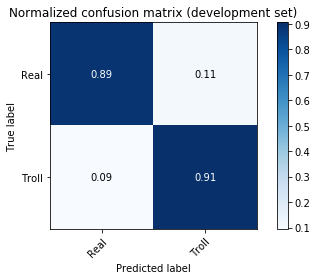

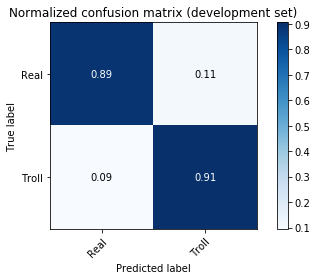

In [22]:
# Non-normalized confusion matrix
plot_confusion_matrix(y_dev, predicted_labels, classes=['Real', 'Troll'], normalize=True,
                      title='Normalized confusion matrix (development set)')

# Normalized confusion matrix
plot_confusion_matrix(y_dev, predicted_labels, classes=['Real', 'Troll'], normalize=True,
                      title='Normalized confusion matrix (development set)')

#### The Most Confused Tweets

In [40]:
# bi-gram vectorizer
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                     token_pattern=r'\b\w+\b', min_df=1)
W_2 = bigram_vectorizer.fit_transform(x_train)
dev_dtm_2 = bigram_vectorizer.transform(x_dev)

# Instantiate logistic regresion object with best C value
tweets = LogisticRegression(penalty='l2', C=opt_C, solver='saga',
                                  multi_class='multinomial', class_weight='balanced', random_state=seed)
tweets.fit(W_2, y_train)

LogisticRegression(C=4.4, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=2019, solver='saga', tol=0.0001, verbose=0,
          warm_start=False)

In [41]:
def max_idx(a,n):
    """ 
    returns a list with the indexes for the n max values in a
    Args:
    ----
    a: list
    n: int
    Returns: list
    """
    return np.argsort(a)[::-1][:n]

In [42]:
def most_confused_tweets(n_examples):

    d = {0 :'real', 1 : 'troll'}
    
    # estimate probabilities for dev data and R ratios
    predicted_labels = tweets.predict(dev_dtm_2)
    probabilities = tweets.predict_proba(dev_dtm_2)
        
    R = [np.max(probabilities[idx,]) / probabilities[idx, label]\
                 for idx, label in zip(range(y_dev.shape[0]), y_dev)]
    
    # find the top n_examples where R is largest
    examples = max_idx(R, n_examples)
    
    # print the examples
    for example in examples:
        true_label = y_dev.values[example]
        print(
            f"Example {example}\n"
            f"True Label: {d[true_label]}\n"
            f"Predicted Label: {d[predicted_labels[example]]}\n" 
            f"R ratio: {R[example]:.2f}\n"
            f"Predicted Probability: {np.max(probabilities[example,])}\n"
            f"Estimated Probability of True label: {probabilities[example, true_label]}\n"
            f"{x_dev.values[example]}\n")

most_confused_tweets(20)

Example 8126
True Label: troll
Predicted Label: real
R ratio: 8448287.63
Predicted Probability: 0.9999998816328319
Estimated Probability of True label: 1.1836716808518283e-07
RT @DanScavino: Reporters bragging POTUS called them out of the blue on Fri are forgetting they sent emails requesting he call for their st…

Example 23425
True Label: troll
Predicted Label: real
R ratio: 602675.90
Predicted Probability: 0.9999983407361406
Estimated Probability of True label: 1.659263859474897e-06
Trump: "Our campaign is about representing the great majority of Americans who turn on the TV &amp; don’t hear anyone speaking for them."

Example 21948
True Label: real
Predicted Label: troll
R ratio: 320212.15
Predicted Probability: 0.9999968770801717
Estimated Probability of True label: 3.1229198282799733e-06
5 things for Monday May 1st: 

1. Donald Trump
2. Weather
3. Turkey
4. Politics
5. Milwaukee jail death… https://t.co/RIUfzZ4OvK

Example 17682
True Label: troll
Predicted Label: real
R ratio: 31

#### Custom Preprocessing

Above, we explored removing the standard English stop words and also the top 10 most frequent words; in both cases, we found that the preprocessing did not improve accuracy. Based on the most confused tweets (above), we tried a more surgical preprocessing strategy. 

In [9]:
def empty_preprocessor(s):
    ''' Preprocessor function that does not do anything, used for control.
    Args:
    ----
        s: string to be processed
    Returns:
        s: string 
    '''
    return s

confusing_words = {'via', 'http', 'https'}

def confusing_words_preprocessor(s):
    words = s.split(' ')
    words = [word for word in words if word not in confusing_words]
    return " ".join(words) 

def better_preprocessor(s):
    
    words = s.split(' ')
    words = [confusing_words_preprocessor(word) for word in words]
    return " ".join(words)  

In [8]:
def prepro_comp(preprocessors):

    for p in preprocessors:
        # compute the vocabulary and transform text into feature vectors using better_preprocessor
        bigram_vectorizer_better = CountVectorizer(preprocessor=p, ngram_range=(1, 2), 
                                             token_pattern=r'\b\w+\b', min_df=1)
        W_2_better = bigram_vectorizer_better.fit_transform(x_train)
        dev_dtm_better_2 = bigram_vectorizer_better.transform(x_dev)

        print (
            f"Preprocessor: {p} \n"
            f"Size of Vocabulary: {W_2_better.shape[1]}")

        # train a logistic regression model 
        tweets1.fit(W_2_better, y_train)
        dev_dtm_better_2 = bigram_vectorizer_better.transform(x_dev)
        predicted_labels = tweets1.predict(dev_dtm_better_2)
        print(f"Accuracy Score: {accuracy_score(y_dev, predicted_labels)*100:.2f}\n")

preprocessors = [None, empty_preprocessor, better_preprocessor]
prepro_comp(preprocessors)

NameError: name 'empty_preprocessor' is not defined

Using the custom preprocesser gives us another small bump in accuracy to 90.03%. However, interestingly, the empty preprocessor is slightly more accurate at 90.10%.

In [10]:
opt_prepro = empty_preprocessor

#### Confused Tweet Stop Words

In [104]:
# Instantiate the vectorizer.
vectorizer_P434 = CountVectorizer(preprocessor=opt_prepro, ngram_range=(1, 2), 
                                             token_pattern=r'\b\w+\b')

# Fit and transform the training data into a document-term matrix.
train_dtm = vectorizer_P434.fit_transform(x_train)

# Transform the development data (using fitted vocabulary) into a document-term matrix.
dev_dtm = vectorizer_P434.transform(x_dev)

# Create a Logistic Regression Classifier 
# and train it using the training set.
logreg_P434 = LogisticRegression(penalty='l2', tol=0.01, C=opt_C, solver='saga',
                    multi_class='multinomial', class_weight='balanced', 
                    random_state=0).fit(train_dtm, y_train)

# Output predictions.
y_pred_P434 = logreg_P434.predict(dev_dtm)

df_P434 = pd.DataFrame(x_dev)
df_P434["actual"] = y_dev
df_P434["predicted"] = y_pred_P434

incorrect = df_P434[df_P434["actual"] != df_P434["predicted"]]
incorrect.head(20)

,tweet_text,actual,predicted
279869,Judge cancels West explosion trial after serie...,0,1
286695,LeBron James’ teammates defeat LeBron James in...,0,1
268868,Al Gore says 'ethical reasons' could end Trump...,0,1
167203,Undocumented activist fights for her children'...,0,1
117946,TV writers seek N.Y. law to boost diversity in...,1,0
229900,"Senators mock photo of ""Brooklyn barbecue"" htt...",0,1
93219,‘Birth of a Nation’ star Nate Parker opens up ...,1,0
242695,wut https://t.co/m4FWOcWxiw,0,1
62518,Herman Wesley Powery II received his Doctor of...,1,0
284879,Judge rips 'privileged' young adults for doing...,0,1


In [105]:
cvec_434 = CountVectorizer()
cvec_434.fit(incorrect.tweet_text)
len(cvec_434.get_feature_names())

12736

In [106]:
real_doc_matrix_i = cvec_434.transform(incorrect[incorrect.actual == 0].tweet_text)
troll_doc_matrix_i = cvec_434.transform(incorrect[incorrect.actual == 1].tweet_text)

real_tf_i = np.sum(real_doc_matrix_i,axis=0)
troll_tf_i = np.sum(troll_doc_matrix_i,axis=0)

real_i = np.squeeze(np.asarray(real_tf_i))
troll_i = np.squeeze(np.asarray(troll_tf_i))

term_freq_df_i = pd.DataFrame([real_i,troll_i],
                            columns=cvec_434.get_feature_names()).transpose()

In [107]:
term_freq_df_i.columns = ['real', 'troll']
term_freq_df_i['total'] = term_freq_df_i['real'] + term_freq_df_i['troll']

In [108]:
term_freq_df_i.sort_values(by='total', ascending=False).iloc[:20]

,real,troll,total
co,2557,1963,4520
https,2554,1960,4514
to,446,417,863
in,406,320,726
the,206,429,635
of,276,266,542
for,244,175,419
trump,110,248,358
on,162,143,305
and,116,176,292


In [109]:
my_stop_words_i = frozenset(list(term_freq_df_i.sort_values(by='total', 
                                                        ascending=False).iloc[:20].index))

In [110]:
print("BIGRAM WITHOUT CORPUS-SPECIFIC STOP WORDS (Top 20 Incorrect)\n")
feature_result_wocswi = nfeature_accuracy_checker(stop_words=my_stop_words_i, 
                                                  ngram_range=(1, 2), 
                                                  n_features = (5, 12000),
                                                  classifier = lr2)

BIGRAM WITHOUT CORPUS-SPECIFIC STOP WORDS (Top 20 Incorrect)

LogisticRegression(C=2.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=0, solver='saga', tol=0.01, verbose=0,
          warm_start=False)


Validation result for 5 features
null accuracy: 50.03%
accuracy score: 57.65%
model is 7.61% more accurate than null accuracy
train and test time: 59.97s
--------------------------------------------------------------------------------
Validation result for 12000 features
null accuracy: 50.03%
accuracy score: 86.34%
model is 36.31% more accurate than null accuracy
train and test time: 43.74s
--------------------------------------------------------------------------------


Accuracy is not improved by removing the incorrect prediction corpus-specific stop words; therefore, it cannot be used for optimization.

### min_df Optimization

In [92]:
'''
Fits a logistic regression model and find the optimal value for min_df. 
'''

def logreg_min_df(min_dfs):

    '''
    Args:
        min_dfs (list): list of min_df values to try
        
    Returns:
        float, accuracy score
    '''
     
    for i in min_dfs:
        
        # Instantiate the vectorizer.
        vectorizer = CountVectorizer(preprocessor=empty_preprocessor, ngram_range=(1, 2), 
                                             token_pattern=r'\b\w+\b', min_df=i)

        # Fit and transform the training data into a document-term matrix.
        train_dtm = vectorizer.fit_transform(x_train)

        # Transform the development data (using fitted vocabulary) into a document-term matrix.
        dev_dtm = vectorizer.transform(x_dev)

        # Create a Logistic Regression Classifier 
        # and train it using the training set.
        logreg_P44 = LogisticRegression(penalty='l2', tol=0.01, C=opt_C, solver='saga',
                            multi_class='multinomial', class_weight='balanced', 
                            random_state=2019).fit(train_dtm, y_train)

        # Output predictions.
        y_pred_P44 = logreg_P44.predict(dev_dtm)
        print('min_df: %d' %(i))
        print('Accuracy: %3.4f' 
              %(metrics.accuracy_score(y_dev, y_pred_P44)))

min_dfs = range(1, 6)
logreg_min_df(min_dfs)

min_df: 1
Accuracy: 0.9008
min_df: 2
Accuracy: 0.8997
min_df: 3
Accuracy: 0.8986
min_df: 4
Accuracy: 0.8977
min_df: 5
Accuracy: 0.8967


Accuracy appears to decline as the min_df value increases; therefore, it cannot be used for optimization.

### max_features Optimization

In [27]:
'''
Fits a logistic regression model and find the optimal value for max_features. 
'''

def logreg_max_feats(max_feats):

    '''
    Args:
        max_feats (list): list of max_features values to try
        
    Returns:
        float, accuracy score
    '''
     
    for i in max_feats:
        
        # Instantiate the vectorizer.
        vectorizer = CountVectorizer(preprocessor=empty_preprocessor, ngram_range=(1, 2), 
                                             token_pattern=r'\b\w+\b', max_features=i)

        # Fit and transform the training data into a document-term matrix.
        train_dtm = vectorizer.fit_transform(x_train)

        # Transform the development data (using fitted vocabulary) into a document-term matrix.
        dev_dtm = vectorizer.transform(x_dev)

        # Create a Logistic Regression Classifier 
        # and train it using the training set.
        logreg_P45 = LogisticRegression(penalty='l2', tol=0.01, C=opt_C, solver='saga',
                            multi_class='multinomial', class_weight='balanced', 
                            random_state=0).fit(train_dtm, y_train)

        # Output predictions.
        y_pred_P45 = logreg_P45.predict(dev_dtm)
        print('max_features: %d' %(i))
        print('Accuracy: %3.4f' 
              %(metrics.accuracy_score(y_dev, y_pred_P45)))

max_feats = (50000, 250000, 500000, 750000, 1000000)
logreg_max_feats(max_feats)

NameError: name 'empty_preprocessor' is not defined

Accuracy appears to increase as the max_features value increases; therefore, it cannot be used for optimization.

## Understanding the Model

In [46]:
# bi-gram vectorizer
bigram_vectorizer = CountVectorizer(preprocessor=opt_prepro, ngram_range=(1, 2),
                                     token_pattern=r'\b\w+\b', min_df=1)
W_5 = bigram_vectorizer.fit_transform(x_train)
dev_dtm_5 = bigram_vectorizer.transform(x_dev)

# Instantiate logistic regresion object with best C value
tweets_5 = LogisticRegression(penalty='l2', C=opt_C, solver='saga',
                                  multi_class='multinomial', class_weight='balanced', random_state=seed)
tweets_5.fit(W_5, y_train)

LogisticRegression(C=4.4, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=2019, solver='saga', tol=0.0001, verbose=0,
          warm_start=False)

### The Largest-Weight Features for Troll Prediction

In [50]:
def features_with_max_weights(lr_object, bow, n):
    
    # find n largest weights for troll
    max_weights_idx = np.argpartition(lr_object.coef_, -n, axis = 1)[:,-n:]
    max_weights_idx = max_weights_idx.flatten()

    # find the associated features
    features_names = bow.get_feature_names()
    max_features = [features_names[w] for w in max_weights_idx]

    # display results
    data = {}
    data = {features_names[idx] : lr_object.coef_[0,idx] for idx in max_weights_idx}
    results = pd.DataFrame.from_dict(data=data, orient='index')
    results.index.name = 'token'
    results.columns = ['weight']
    results.sort_values(by=['weight'], inplace=True, ascending=False)
    return results

In [51]:
# which are the features with largest weight that predict a troll with bigram vocabulary?
features_with_max_weights(tweets_5, bigram_vectorizer, 50)

,weight
token,
politics,4.681976
ObservationsAtTheMarathon,4.566177
StLouis,4.292407
showbiz,4.147673
sports,3.944751
SanJose,3.849421
news,3.708573
The Latest,3.445652
health,3.395919


### The "Trolliest" Tweets

In [52]:
def trolliest_tweets(n_examples):
    
    # estimate probabilities for dev data 
    predicted_labels = tweets_5.predict(dev_dtm_5)
    probabilities = tweets_5.predict_proba(dev_dtm_5)

    max_prob = np.max(probabilities, axis=1)
    sorted_max_prob = np.argsort(max_prob)[::-1]
    
    texts = []
    examples = 0
    
    for idx in sorted_max_prob:
        if predicted_labels[idx] == 1:
            texts.append(x_dev.values[idx])
            examples += 1
            if examples == n_examples:
                break
    return texts
    
trolliest_tweets(20)

['Local sports digest: San Jose State third, Cal fourth after first round of Bay Area Intercollegiate  #sports',
 'Kyrie Irving continues to progress for Cleveland Cavs: Cleveland Cavaliers point guard Kyri... https://t.co/i7pWHybj11 #Cleveland #sports',
 'Bay Area sports fans sought for Super Bowl 50 Halftime Show  #news',
 '#Idlib | Renewed clashes between Suqour al-Sham Brigade (Ahrar al-Sham) and Jabhat Fatah al-Sham near Ehsim town https://t.co/hX6OiW8aIk',
 "Shumpert is Cleveland Cavs' 'glue guy': Shooting guard\xa0Iman Shumpert is the Cleveland Caval... https://t.co/qCZz8aGcie #Cleveland #sports",
 "Local sports digest: Santa Clara women's basketball coach Payne departs  #sports",
 'Missouri business groups divided on LGBT-discrimination ban  #business #news',
 'Biggest Winner for February 10, 2016: The "Biggest Winner" in local sports for Wednesday Fe... https://t.co/Xx6G71UAcd #Cleveland #sports',
 'San Jose Sharks beat Edmonton Oilers 2-1 in shootout, Todd McLellan returns to

### The "Realest" Tweets

In [53]:
def realest_tweets(n_examples):
    
    # estimate probabilities for dev data 
    predicted_labels = tweets_5.predict(dev_dtm_5)
    probabilities = tweets_5.predict_proba(dev_dtm_5)

    max_prob = np.max(probabilities, axis=1)
    sorted_max_prob = np.argsort(max_prob)[::-1]
    
    texts = []
    examples = 0
    
    for idx in sorted_max_prob:
        if predicted_labels[idx] == 0:
            texts.append(x_dev.values[idx])
            examples += 1
            if examples == n_examples:
                break
    return texts
    
realest_tweets(20)

['RT @MSNBC: NEW: @kwelkernbc reports that the White House says the decision on whether to release the Nunes memo will not be rushed and Pres…',
 'RT @ABC: JUST IN: Pres. Trump announces tariffs on $50 billion of Chinese technological goods.\n\n"The United States will implement a 25 perc…',
 'RT @NBCPolitics: JUST IN: The White House pre-advance team for North Korea summit will travel to Singapore as scheduled "in order to prepar…',
 'RT @NBCNews: BREAKING: Conservative Republican Roy Moore defeats Senator Luther Strange, who had been endorsed by President Trump, in Alaba…',
 'RT @FoxBusiness: .@JamieColbyTV joined @TeamCavuto with a preview of the ALL NEW season of #StrangeInheritance. Tune in tonight at 9pm ET o…',
 "RT @hardball: BREAKING: Robert Mueller's prosecutors told Paul Manafort they plan to indict him. (per @nytimes) WATCH:  https://t.co/AClfEe…",
 "RT @ABC: MORE: EPA's internal watchdog to expand review of Scott Pruitt's conduct to include his arrangement to live in a Capi

## Implementation

### Final Model

In [73]:
# Final model goes here. Run with test data.

### Calibration

After evaluation our model, using calibratation, we realized that a smaller c-value would improve calibration which is crucial to make a good assessment of risks. We will use c=0.17, which slighlty decreases accuracy by 0.08 percent points.

In [12]:
bigram_vectorizer_better = CountVectorizer(preprocessor=opt_prepro, ngram_range=(1, 2),
                                             token_pattern=r'\b\w+\b', min_df=1)
W_better = bigram_vectorizer_better.fit_transform(x_train)
dev_dtm_better = bigram_vectorizer_better.transform(x_dev)

# Instantiate logistic regresion object
tweets_5 = LogisticRegression(penalty='l2', C=opt_C, solver='saga',
                                  multi_class='multinomial', class_weight='balanced', random_state=seed)
tweets_5.fit(W_better, y_train)


LogisticRegression(C=0.17, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=2019, solver='saga', tol=0.0001, verbose=0,
          warm_start=False)

#### Plot Calibration

p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.6000000000000    total = 1825    accuracy = 0.565
p(pred) <= 0.7000000000000    total = 2105    accuracy = 0.658
p(pred) <= 0.8000000000000    total = 2682    accuracy = 0.791
p(pred) <= 0.9000000000000    total = 4138    accuracy = 0.874
p(pred) <= 0.9100000000000    total = 611    accuracy = 0.908
p(pred) <= 0.9200000000000    total = 646    accuracy = 0.935
p(pred) <= 0.9300000000000    total = 714    accuracy = 0.951
p(pred) <= 0.9400000000000    total = 846    accuracy = 0.948
p(pred) <= 0.9500000000000    total = 1062    accuracy = 0.948
p(pred) <= 0.9600000000000    total = 1211    accuracy = 0.964
p(pred) <= 0.9700000000000    total = 1411    accuracy = 0.953
p(pred) <= 0.9800000000000    total = 1894    accuracy = 0.978
p(pred) <= 0.9900000000000    total = 2876    accuracy = 0.986
p(pred) <= 0.9990000000000    total = 6001    accuracy = 0.995
p(pred) <= 0.9999000000000    total = 2005    accuracy = 0.9

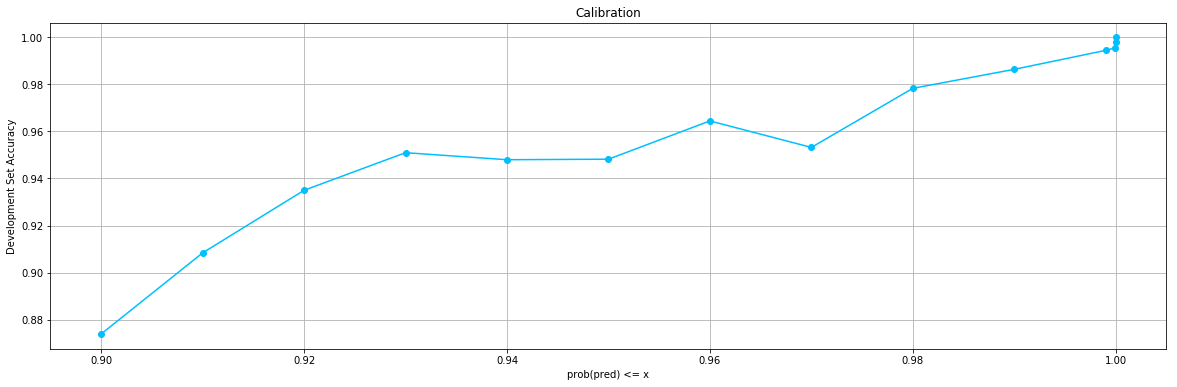

In [15]:
buckets = [0.5, 0.6, 0.7, 0.8, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
           0.99, 0.999, 0.9999, 0.99999, 1.0]

''' Given a posterior probability returns the bucket.
'''
def find_bucket(post):
    for idx,b in enumerate(buckets):
        if post <= b:
            return idx

def calibration(lr_object, X, Y):
        
    # initialize the buckets
    correct = [0 for i in buckets]
    total = [0 for i in buckets]

    # get predicted labels and posterior probabilities 
    predicted_labels = tweets_5.predict(X)
    post = lr_object.predict_proba(X)

    # find max posterior probability for each sample in dev data
    max_prob=np.max(post,axis=1)

    for post, pred, label in zip(max_prob, predicted_labels, Y):
        idx = find_bucket(post)
        if pred == label:
            correct[idx] += 1
        total[idx] += 1
    
    for i in range(len(buckets)):
        acc = 0.0
        if (total[i] > 0): 
            acc = correct[i] / total[i]
        print( 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], acc))
    
    # plot accuracies vs buckets
    accuracies = []
    for i in range(4, len(buckets)):
        accuracies.append(correct[i] / total[i])
    
    plt.figure(figsize=(20,6))

    plt.plot(buckets[4:], accuracies, marker = "o", color="deepskyblue")
    plt.title("Calibration")
    plt.xlabel(f"prob(pred) <= x")
    plt.ylabel("Development Set Accuracy")
    plt.grid()
    plt.savefig('calibration.jpg')

calibration(tweets_5, dev_dtm_better, y_dev)

As we expected, Logistic Regression returns well calibrated predictions. Generally higher probalities are associated with higher accuracies. For values of accuracies above 0.94, we could say that the model is strongly calibrated with the exception of the interval around prob(pred) in (0.96, 0.97)

#### Confidence Thresholds


    Examples: 30638
    Predicted Trolls: 15672
    Predicted News: 14966


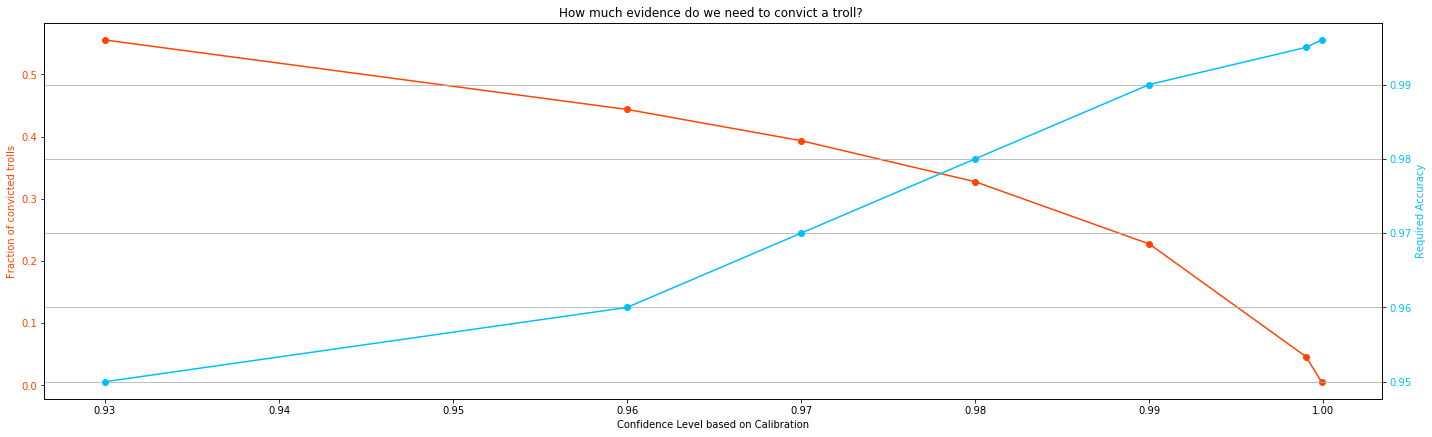

[0.5553854007146504, 0.44372128637059727, 0.3934405308831036, 0.3274629913221031, 0.22741194486983154, 0.04626084737110771, 0.005806533945890761]
[(0.95, 0.93), (0.96, 0.96), (0.97, 0.97), (0.98, 0.98), (0.99, 0.99), (0.995, 0.999), (0.996, 0.9999), (1.0, 1.0)]


In [16]:
# each tuple is a pair of (accuracy, probability) based on the results of calibration above
thresholds = [(0.95, 0.93), (0.96, 0.96), (0.97, 0.97), (0.98, 0.98), 
              (0.99, 0.99), (0.995, 0.999), (0.996, 0.9999), (1.0, 1.0)]

def find_threshold(post):
    for idx, threshold in enumerate(thresholds):
        if post <= threshold[1]:
            return idx

def dont_know(lr_object, X, Y):
    
    # initialize
    troll = 1
    dont_know = [0 for i in thresholds]
    total = len(Y)
    
    # get predicted labels and posterior probabilities 
    predicted_labels = lr_object.predict(X)
    post = lr_object.predict_proba(X)
    
    total_predicted_trolls = np.sum(predicted_labels==1)
    total_predicted_news = total - total_predicted_trolls
    print(f"""
    Examples: {total}
    Predicted Trolls: {total_predicted_trolls}
    Predicted News: {total_predicted_news}""")

    # find max posterior probability for each sample in dev data
    max_prob=np.max(post,axis=1)
    
    for post, pred in zip(max_prob, predicted_labels):
        
        if pred == troll: 
            idx = find_threshold(post)
            dont_know[idx] +=1
    
    convicted_trolls = [0 for i in thresholds]
    for i in range(len(dont_know)):
        convicted_trolls[i] = (total_predicted_trolls-sum(dont_know[:i+1])) / total_predicted_trolls

    # plot fraction of "convicted trolls" vs thresholds
    convicted_trolls = convicted_trolls[:-1]
    confidence_level = [t[1] for t in thresholds[:-1]]
    accuracy = [t[0] for t in thresholds[:-1]]

    fig, ax1 = plt.subplots(figsize=(20,6))

    color = 'orangered'
    ax1.set_xlabel('Confidence Level based on Calibration')
    ax1.set_ylabel("Fraction of convicted trolls", color=color)
    ax1.plot(confidence_level, convicted_trolls, marker = "o", color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  

    color = 'deepskyblue'
    ax2.set_ylabel('Required Accuracy', color=color)  
    ax2.plot(confidence_level, accuracy, marker = "o", color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout() 
    plt.title("How much evidence do we need to convict a troll? ")
    plt.grid()
    plt.show()
    fig.savefig('I dont know.jpg')
    print(convicted_trolls)
    print(thresholds)

dont_know(tweets_5, dev_dtm_better, y_dev)

## Conclusions

### Data quality is as important as algorithm quality.

### Utility is as important as complexity.

We tried some complex algorithms, including ensemble models, random forests, and Doc2Vec. However, in the end, it’s really hard to beat logistic regression! As simple as it is - it just works.

### Process is as important as processing.

## Suggestions for Future Work

### ML Engineering
- Is there additional preprocessing and/or parameter tuning that would increase the model's accuracy?
- Would additional data improve our model? Since we have almost 500,000 features, it would be good to have at least as many examples in our training set.
- Can our algorithm pick out a troll from a random selection of tweets?
- Would our algorithm work for identifying other trolls (e.g. the Venezuelan trolls)?

### Implementation
- How could the algorithm be implemented by Twitter? What other work is required to make the algorithm useful in practice?  
- Does the algorithm transcend the specifics of the political context of the training data?
- How could the algorithm be ‘tricked’ or ‘gamed’?

### Fairness
- Does the algorithm have the potential to falsely identify legitimate users as trolls? 
- How could it be misused?

### Legality
- What are the legal issues involved with suspending accounts using machine learning? 
- Does curtailing troll activity necessarily infringe on free speech? Would this be a bigger concern if the trolls were American citizens?

### Research
- What was the practical impact of these trolls' tweets? Did they actually influence people to change their votes in 2016?
- Who was directing the IRA? How was it funded?